<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/TimeDistributedCNN%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 2346, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 2346 (delta 18), reused 29 (delta 13), pack-reused 2307
Receiving objects: 100% (2346/2346), 330.86 MiB | 23.86 MiB/s, done.
Resolving deltas: 100% (538/538), done.
Checking out files: 100% (1900/1900), done.
/content/STAT3007_Project


In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
import glob

In [19]:

def spectral_decomposition(sample,sampling_rate, eps = 1e-14, title = ' title placeholder', visualise = False):
    frequencies, times, spectrogram = scipy.signal.spectrogram(sample,fs = sampling_rate)

    
    
    
    if visualise:
      specgram = plt.pcolormesh(times, frequencies, np.log(spectrogram + eps),shading = 'auto')
      plt.clim(-40, -5)
      
      plt.colorbar(specgram)
      #plt.imshow(np.log(spectrogram))
      plt.ylabel('Frequency [Hz]')
      plt.xlabel('Time [sec]')
      plt.title(title)
      plt.show()
    
    return frequencies, times, np.log(spectrogram+ eps)

In [ ]:

class TimeDistributed(nn.Module):
    def __init__(self, segments):
        super(TimeDistributed, self).__init__()

        self.segments = segments
        self.flatten = nn.Flatten()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(32, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )


        self.lstm_layer = nn.LSTM(1024,100,2)
        self.linear = nn.Sequential(nn.Linear(100, 5),
                                    nn.Sigmoid())

    def forward(self, x, use_cuda = False):

      # initial cell/hidden state
      # (num_layers, batch, hidden_size)
      if use_cuda:
        h_t = torch.zeros(2,1 ,100, dtype=torch.float).to(x.device)
        c_t = torch.zeros(2,1, 100, dtype=torch.float).to(x.device)

      else:
        h_t = torch.zeros(2,1, 100, dtype=torch.float)
        c_t = torch.zeros(2,1, 100, dtype=torch.float)

      # generate output of each prediction based on input
      start = 0
      step_size = int((x.shape[1]/self.segments))
      end = step_size

      for segment in range(segments):
        
        input_t = x[:,start:end]

        start = end
        end = end + step_size

        input_t = self.conv(input_t)
        input_t = self.flatten(input_t)
        # send info of previous cell/hidden state to the next layer
        # input the next character on the provided sequence
        h_t, c_t = self.lstm(input_t, (h_t, c_t))
        output = self.linear(h_t)
      
      return outputs

In [46]:
# produce emotion label

target_map = {'02':0,'03':1,'04':2,'05':3,'08':4}

def target_generation(file_name):
  labels = file_name.split('.')[0].split('-')
  emotion = labels[0]

  if emotion not in target_map:
    return None

  return target_map[emotion]

In [74]:
# load samples
X = []
y = []

min_time = 41241
max_time = 0
max_sample = 0
for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
  for actor_folder in glob.glob(folder_name + '/*'):
    for sample_path in glob.glob(actor_folder + '/*'):
      
      sample_name = sample_path.split('/')[-1]
      file_format = sample_name.split('.')[-1]

      if file_format != 'wav' or sample_name[:2] not in target_map:
        continue

      sample, sampling_rate = librosa.load(sample_path, sr = None)
      sampling_time = sample.shape[0]/sampling_rate

      frequencies, times, spectrogram = spectral_decomposition(sample, sampling_rate)

      if sampling_time < min_time:
        min_time = sampling_time
        min_sample = (sample,sampling_rate, sample_path)

      if sampling_time > max_time:
        max_time = sampling_time
        max_sample = (sample,sampling_rate, sample_path)
      
      target = target_generation(sample_name)

      if target != None:
        X.append(spectrogram)
        y.append(target)
    


#Current Problem
The time steps for speech data is not the same.

proposed solution:
1. test data - no changes
2. training data - pad all the samples to max length. Since we want our network to be independent of audio length, we can do data augmentation to break them apart. (source https://arxiv.org/pdf/1607.02857.pdf)

3. must read: effect of padding on CNN and LSTM (https://arxiv.org/pdf/1903.07288.pdf)
 * Acoording to the paper, prepadding is good for LSTM and CNN. So we choose __pre-padding__ the samples

In [77]:
print(max_sample[2])
print(min_sample[2])

./Audio_Speech_Actors_01-24/Female/Actor_24/05-02-02-02-24.wav
./Audio_Speech_Actors_01-24/Male/Actor_13/02-01-02-02-13.wav


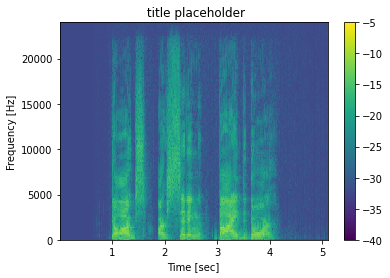

In [75]:
a,b,c = spectral_decomposition(max_sample[0],max_sample[1],visualise = True)

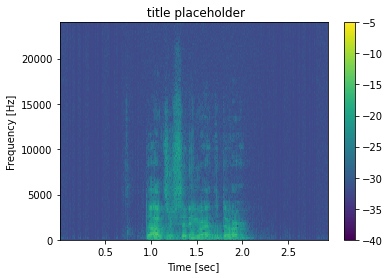

In [76]:
a,b,c = spectral_decomposition(min_sample[0],min_sample[1],visualise = True)